##**Embed generated data with Meteo Docs**

In [1]:
!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 7.8 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.preprocessing import MinMaxScaler

import psycopg2
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Source: https://open-meteo.com/

In [3]:
api_data = requests.get("https://api.open-meteo.com/v1/forecast?latitude=-6.364453&longitude=106.827161&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,weather_code,evapotranspiration,wind_speed_10m,wind_direction_10m&start_date=2024-03-13&end_date=2024-03-23").json()

api_df = pd.DataFrame(
    {'timestamp'         : api_data['hourly']['time'],
     'humidity'          : api_data['hourly']['relative_humidity_2m'],
     'dew_point_2m'      : api_data['hourly']['dew_point_2m'],
     'precipitation'     : api_data['hourly']['precipitation'],
     'rain'              : api_data['hourly']['rain'],
     'weather_code'      : api_data['hourly']['weather_code'],
     'evapotranspiration': api_data['hourly']['evapotranspiration'],
     'wind_speed'        : api_data['hourly']['wind_speed_10m'],
     'wind_direction'    : api_data['hourly']['wind_direction_10m']})

api_df['timestamp'] = api_df['timestamp'].map(lambda x : x.replace('-', '').replace(':', '').replace('T', ''))
api_df.head()

,timestamp,humidity,dew_point_2m,precipitation,rain,weather_code,evapotranspiration,wind_speed,wind_direction
0,202403130000,90,23.5,0.0,0.0,3,0.03,5.7,235
1,202403130100,87,23.5,0.0,0.0,3,0.06,6.9,261
2,202403130200,85,23.8,0.2,0.0,3,0.12,7.6,265
3,202403130300,83,24.3,0.1,0.0,3,0.18,7.2,270
4,202403130400,78,24.5,0.1,0.0,3,0.18,9.2,301


In [4]:
def convert_to_gmt7(timestamp_str):
    timestamp_dt = datetime.strptime(timestamp_str, "%Y%m%d%H%M")
    timestamp_dt_gmt7 = timestamp_dt + timedelta(hours=7)
    return timestamp_dt_gmt7.strftime("%Y%m%d%H%M")

# Apply the function to the timestamp column
api_df['timestamp'] = api_df['timestamp'].apply(convert_to_gmt7)
api_df.head()

,timestamp,humidity,dew_point_2m,precipitation,rain,weather_code,evapotranspiration,wind_speed,wind_direction
0,202403130700,90,23.5,0.0,0.0,3,0.03,5.7,235
1,202403130800,87,23.5,0.0,0.0,3,0.06,6.9,261
2,202403130900,85,23.8,0.2,0.0,3,0.12,7.6,265
3,202403131000,83,24.3,0.1,0.0,3,0.18,7.2,270
4,202403131100,78,24.5,0.1,0.0,3,0.18,9.2,301


In [5]:
db_password = userdata.get('db_password')
db_user     = userdata.get('db_user')
db_name     = userdata.get('db_name')
db_host     = userdata.get('db_host')
db_port     = userdata.get('db_port')

In [6]:
conn = psycopg2.connect(
    host     = db_host,
    port     = db_port,
    database = db_name,
    user     = db_user,
    password = db_password)

cursor = conn.cursor()

In [7]:
cursor.execute("select * from sensors")
result = cursor.fetchall()

df_raw = pd.DataFrame(result, columns=['id', 'timestamp', 'longitude', 'latitude', 'temperature', 'moisture', 'suction_pressure', 'sensor_id']).drop(columns=['id', 'sensor_id'])
df_raw = df_raw.drop_duplicates(subset=['timestamp'])

df_raw['timestamp'] = df_raw['timestamp'].dt.strftime("%Y%m%d%H%M%S")
df_raw.head()

,timestamp,longitude,latitude,temperature,moisture,suction_pressure
0,20240316095708,106.830208,-6.367975,25.5,16.4,12.173478
1,20240316095734,106.830208,-6.367975,25.5,16.4,12.102830
2,20240316095800,106.830208,-6.367975,25.5,16.4,12.034261
3,20240316095827,106.830208,-6.367975,25.5,16.4,11.965333
4,20240316095854,106.830208,-6.367975,25.5,16.4,11.895782


In [8]:
# Checking if time is already unique
len(df_raw['timestamp'].unique()) == len(df_raw)

True

In [9]:
# Cleaning unwanted data
clean_error_data = df_raw.loc[(df_raw['moisture'] == 0)].index
df_raw = df_raw.drop(clean_error_data)
df_raw

,timestamp,longitude,latitude,temperature,moisture,suction_pressure
0,20240316095708,106.830208,-6.367975,25.5,16.400000,12.173478
1,20240316095734,106.830208,-6.367975,25.5,16.400000,12.102830
2,20240316095800,106.830208,-6.367975,25.5,16.400000,12.034261
3,20240316095827,106.830208,-6.367975,25.5,16.400000,11.965333
4,20240316095854,106.830208,-6.367975,25.5,16.400000,11.895782
...,...,...,...,...,...,...
699,20240316152203,106.826504,-6.360774,25.9,32.599998,13.830505
700,20240316152230,106.826504,-6.360774,25.9,32.599998,13.842901
701,20240316152256,106.826504,-6.360774,25.9,32.599998,13.847981
702,20240316152326,106.826504,-6.360774,25.9,32.599998,13.855848


## Preprocessing

Weather Interpretation Code:

https://gist.github.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c

In [10]:
def get_nearest_hour(timestamp_str):
    dt = datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    nearest_hour = dt.hour
    nearest_dt = datetime(dt.year, dt.month, dt.day, nearest_hour)

    # Convert the result back to a string
    return str(nearest_dt.strftime('%Y%m%d%H%M'))

# Test the function
timestamps = ['20240219113501', '20240219123511', '20240219173523', '20240218210514']

for timestamp in timestamps:
    nearest_timestamp = get_nearest_hour(timestamp)
    print(f"For timestamp {timestamp}, nearest timestamp is {nearest_timestamp}")

For timestamp 20240219113501, nearest timestamp is 202402191100
For timestamp 20240219123511, nearest timestamp is 202402191200
For timestamp 20240219173523, nearest timestamp is 202402191700
For timestamp 20240218210514, nearest timestamp is 202402182100


In [11]:
def map_attribute(timestamp, attribute=None):
    nearest_timestamp = get_nearest_hour(timestamp)
    if attribute is not None:
      if nearest_timestamp in list(api_df['timestamp']):
          return api_df.loc[api_df['timestamp'] == nearest_timestamp, attribute].iloc[0]
      else:
          return None
    else:
      return None

for attr in list(api_df.columns[1:]):
    df_raw[attr] = df_raw['timestamp'].apply(map_attribute, attribute=attr)

df_raw.drop(columns=['timestamp'], inplace=True)

In [ ]:
# # Sort the DataFrame by timestamp
# df_moisture = df_moisture.sort_values(by='timestamp')

# # Create an empty list to store mean moisture values
# mean_moisture_values = []
# mean_suction_values  = []

# # Iterate over each row in the DataFrame
# for index, row in df_moisture.iterrows():
#     # Filter the DataFrame up to the current row's timestamp and group by combine_loc
#     filtered_df_m = df_moisture[df_moisture['timestamp'] <= row['timestamp']].groupby('combine_loc')['moisture'].mean()

#     # Calculate the mean moisture for the current location up to the current timestamp
#     mean_moisture = filtered_df_m[row['combine_loc']]

#     # Append the mean moisture value to the list
#     mean_moisture_values.append(mean_moisture)

# # Add the list of mean moisture values as a new column to the DataFrame
# df_moisture['mean_moisture'] = mean_moisture_values
# df_moisture.drop(columns=['timestamp', 'latitude', 'longitude', 'combine_loc'], inplace=True)


# # Sort the DataFrame by timestamp
# df_suction = df_suction.sort_values(by='timestamp')

# # Create an empty list to store mean moisture values
# mean_suction_values  = []

# # Iterate over each row in the DataFrame
# for index, row in df_suction.iterrows():
#     # Filter the DataFrame up to the current row's timestamp and group by combine_loc
#     filtered_df_s = df_suction[df_suction['timestamp'] <= row['timestamp']].groupby('combine_loc')['suction_pressure'].mean()

#     # Calculate the mean moisture for the current location up to the current timestamp
#     mean_suction  = filtered_df_s[row['combine_loc']]

#     # Append the mean moisture value to the list
#     mean_suction_values.append(mean_suction)

# # Add the list of mean moisture values as a new column to the DataFrame
# df_suction['curr_point_mean_suction'] = mean_suction_values
# df_suction.drop(columns=['timestamp', 'latitude', 'longitude', 'combine_loc'], inplace=True)
# df_suction

In [12]:
df_raw.weather_code.unique()

array([ 3, 95, 80,  2])

In [13]:
weather_dict = {
    2: 'Partly Cloudy',
    3: 'Cloudy',
    80: 'Light Showers',
    95: 'Thunderstorm',
    96: 'Light Thunderstorms With Hail'
}

df = df_raw.copy()

df['combine_loc'] = '(' + df['latitude'].astype(str) + ', ' + df['longitude'].astype(str) + ')'
# df['weather'] = df['weather_code'].map(weather_dict)

In [14]:
# The type of the weather can be so many so that it will be too sparsed if we include all the weather.
# df_enc = pd.get_dummies(df['weather'], dtype=int, drop_first=True)
# df = pd.concat([df, df_enc], axis=1)

df_moisture = df.copy()
df_suction  = df.loc[df['suction_pressure'] != 0].copy()

In [38]:
df_moisture.head(15)

,longitude,latitude,temperature,moisture,suction_pressure,humidity,dew_point_2m,precipitation,rain,weather_code,evapotranspiration,wind_speed,wind_direction,combine_loc
0,106.830208,-6.367975,25.5,16.4,12.173478,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
1,106.830208,-6.367975,25.5,16.4,12.102830,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
2,106.830208,-6.367975,25.5,16.4,12.034261,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
3,106.830208,-6.367975,25.5,16.4,11.965333,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
4,106.830208,-6.367975,25.5,16.4,11.895782,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
5,106.830208,-6.367975,25.5,16.4,11.827001,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
6,106.830208,-6.367975,25.5,16.4,11.760812,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
7,106.830208,-6.367975,25.5,16.4,11.695539,75,23.6,0.0,0.0,3,0.22,12.3,277,"(-6.367975, 106.830208)"
8,106.830208,-6.367975,25.5,16.4,11.630370,75,23.6,0.0,0.0,3,0.22,12.3,277,"(-6.367975, 106.830208)"
9,106.830208,-6.367975,25.5,16.4,11.564996,75,23.6,0.0,0.0,3,0.22,12.3,277,"(-6.367975, 106.830208)"


In [16]:
df_suction.head()

,longitude,latitude,temperature,moisture,suction_pressure,humidity,dew_point_2m,precipitation,rain,weather_code,evapotranspiration,wind_speed,wind_direction,combine_loc
0,106.830208,-6.367975,25.5,16.4,12.173478,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
1,106.830208,-6.367975,25.5,16.4,12.102830,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
2,106.830208,-6.367975,25.5,16.4,12.034261,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
3,106.830208,-6.367975,25.5,16.4,11.965333,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"
4,106.830208,-6.367975,25.5,16.4,11.895782,82,23.9,0.0,0.0,3,0.12,8.5,282,"(-6.367975, 106.830208)"


Our hypothesis, suction and moisture will be correlated to the wetness affecting attribute.

* Rain
* Precipitation
* Evapotranspiration

#### **Suction Pressure Analysis**

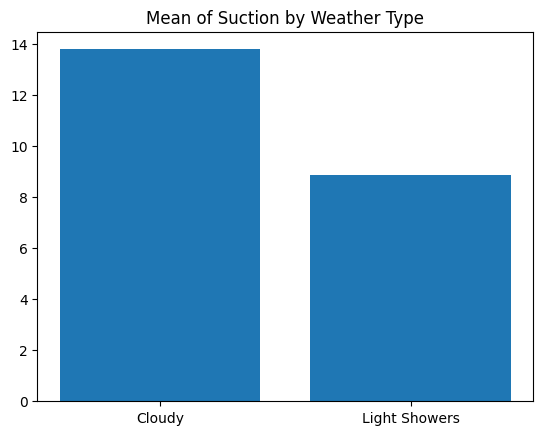

In [17]:
suction_by_weather = dict(df_suction.groupby('weather_code')['suction_pressure'].mean())
mapped_suction_by_weather = {weather_dict[key]: value for key, value in suction_by_weather.items()}

plt.title('Mean of Suction by Weather Type')
plt.bar(mapped_suction_by_weather.keys(), mapped_suction_by_weather.values())
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


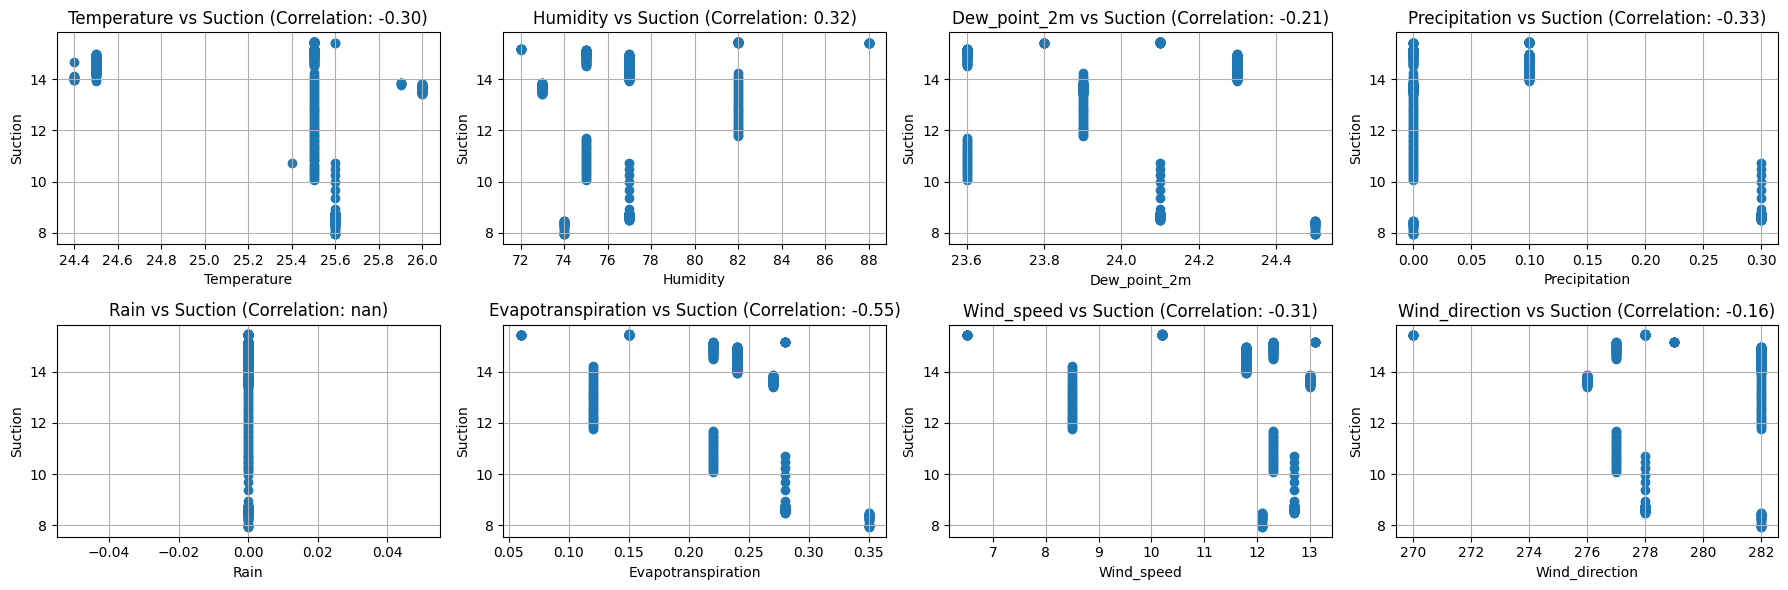

In [18]:
import matplotlib.pyplot as plt
import numpy as np

suction_analysis = ['temperature', 'humidity', 'dew_point_2m', 'precipitation', 'rain', 'evapotranspiration', 'wind_speed', 'wind_direction']

# Assuming df_suction is your DataFrame containing the data

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(18, 6))

# Iterate over rows and columns of the 2D axes array
for i in range(2):
    for j in range(4):
        ax = axes[i, j]  # Get the current subplot
        var_index = i * 4 + j  # Calculate the index for accessing the variable
        if var_index < len(suction_analysis):  # Check if there are variables left to plot
            var = suction_analysis[var_index]  # Get the variable name
            # Calculate correlation coefficient
            correlation = np.corrcoef(df_suction['suction_pressure'], df_suction[var])[0, 1]
            # Create the scatter plot on the current subplot
            ax.scatter(df_suction[var], df_suction['suction_pressure'])
            ax.set_xlabel(var.capitalize())
            ax.set_ylabel("Suction")
            ax.set_title("{} vs Suction (Correlation: {:.2f})".format(var.capitalize(), correlation))
            ax.grid(True)
        else:
            # If there are no more variables to plot, hide the current subplot
            ax.axis('off')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


#### **Moisture Pressure Analysis**

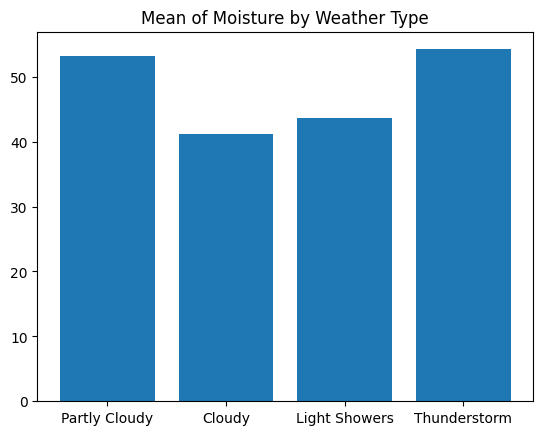

In [19]:
moisture_by_weather = dict(df_moisture.groupby('weather_code')['moisture'].mean())
mapped_moisture_by_weather = {weather_dict[key]: value for key, value in moisture_by_weather.items()}

plt.title('Mean of Moisture by Weather Type')
plt.bar(mapped_moisture_by_weather.keys(), mapped_moisture_by_weather.values())
plt.show()

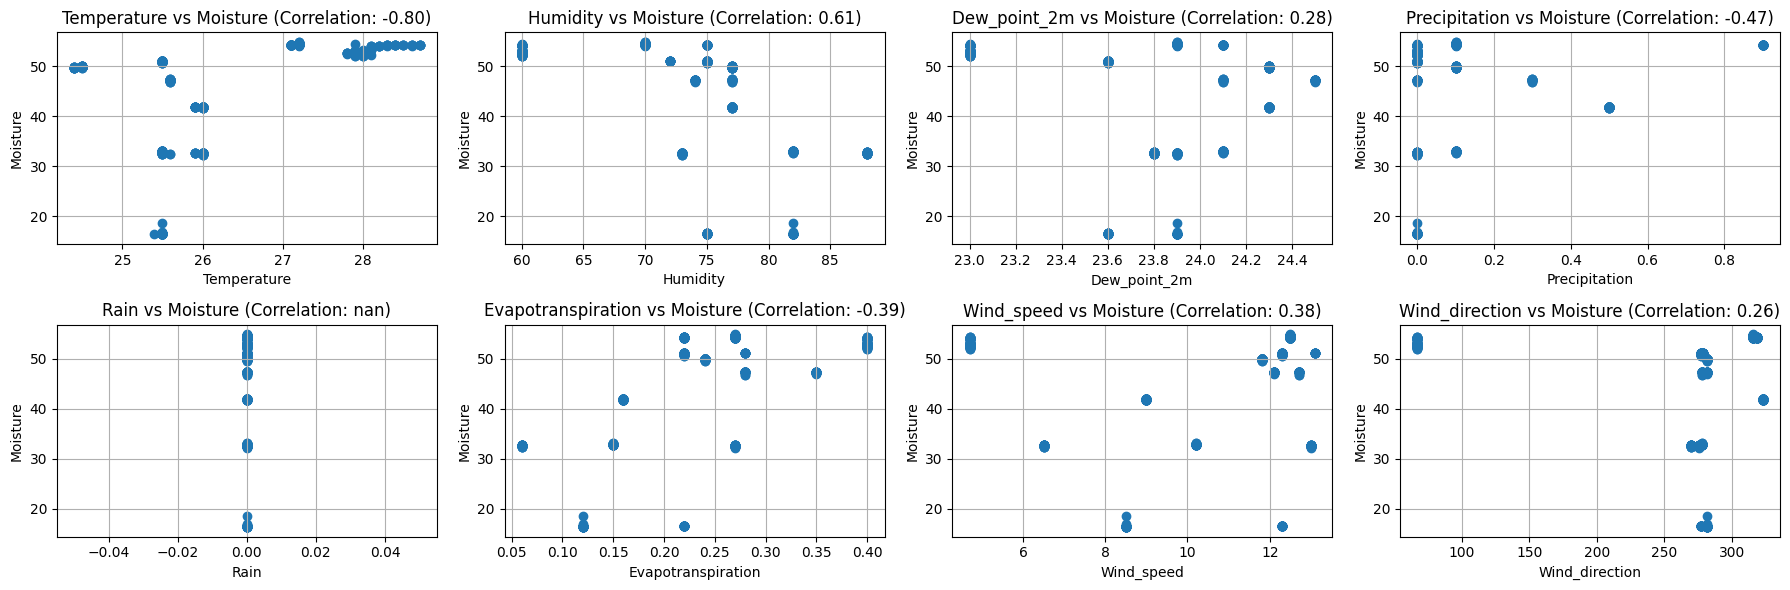

In [20]:
moisture_analysis = ['temperature', 'humidity', 'dew_point_2m', 'precipitation', 'rain', 'evapotranspiration', 'wind_speed', 'wind_direction']

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(18, 6))

# Iterate over rows and columns of the 2D axes array
for i in range(2):
    for j in range(4):
        ax = axes[i, j]  # Get the current subplot
        var_index = i * 4 + j  # Calculate the index for accessing the variable
        if var_index < len(moisture_analysis):  # Check if there are variables left to plot
            var = moisture_analysis[var_index]  # Get the variable name
            correlation = np.corrcoef(df_moisture['suction_pressure'], df_moisture[var])[0, 1]
            # Create the scatter plot on the current subplot
            ax.scatter(df_moisture[var], df_moisture['moisture'])
            ax.set_xlabel(var.capitalize())
            ax.set_ylabel("Moisture")
            ax.set_title("{} vs Moisture (Correlation: {:.2f})".format(var.capitalize(), correlation))
            ax.grid(True)
        else:
            # If there are no more variables to plot, hide the current subplot
            ax.axis('off')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
def check_outliers_by_column(df, cols):
  outliers_dict = {}
  for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = outliers.copy()  # avoid modifying original dataframe
  return outliers_dict

In [22]:
cols_to_check_suction = ['temperature', 'humidity', 'dew_point_2m', 'precipitation', 'rain', 'evapotranspiration', 'wind_speed', 'wind_direction']
outliers_by_col = check_outliers_by_column(df_suction.copy(), cols_to_check_suction)

# Print outliers for each column
for col, outliers in outliers_by_col.items():
  if not outliers.empty:
    print(f"There are outliers for column {col}:", len(outliers))
  else:
    print(f"No outliers detected for column {col}.")

No outliers detected for column temperature.
No outliers detected for column humidity.
No outliers detected for column dew_point_2m.
There are outliers for column precipitation: 39
No outliers detected for column rain.
No outliers detected for column evapotranspiration.
There are outliers for column wind_speed: 23
No outliers detected for column wind_direction.


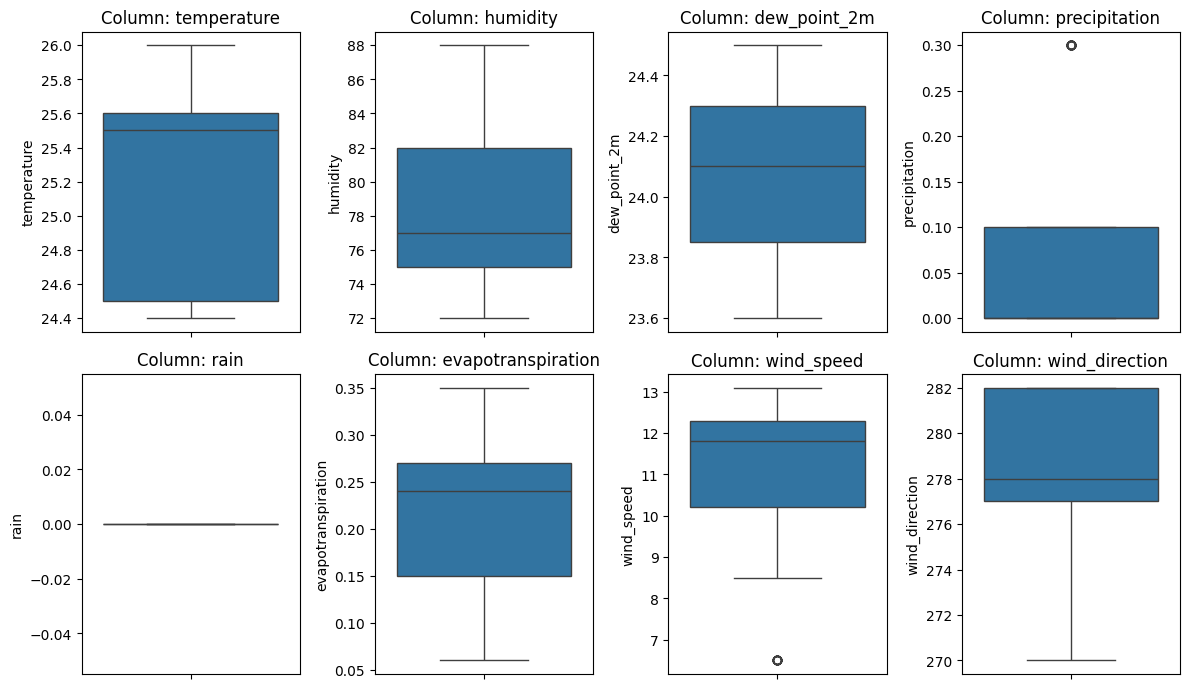

In [23]:
# Create a 4x2 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over columns and plot on each subplot
for i, col in enumerate(cols_to_check_suction):
    sns.boxplot(data=df_suction[col], ax=axes[i])
    axes[i].set_title(f'Column: {col}')

# Hide the empty subplots
for j in range(len(cols_to_check_suction), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

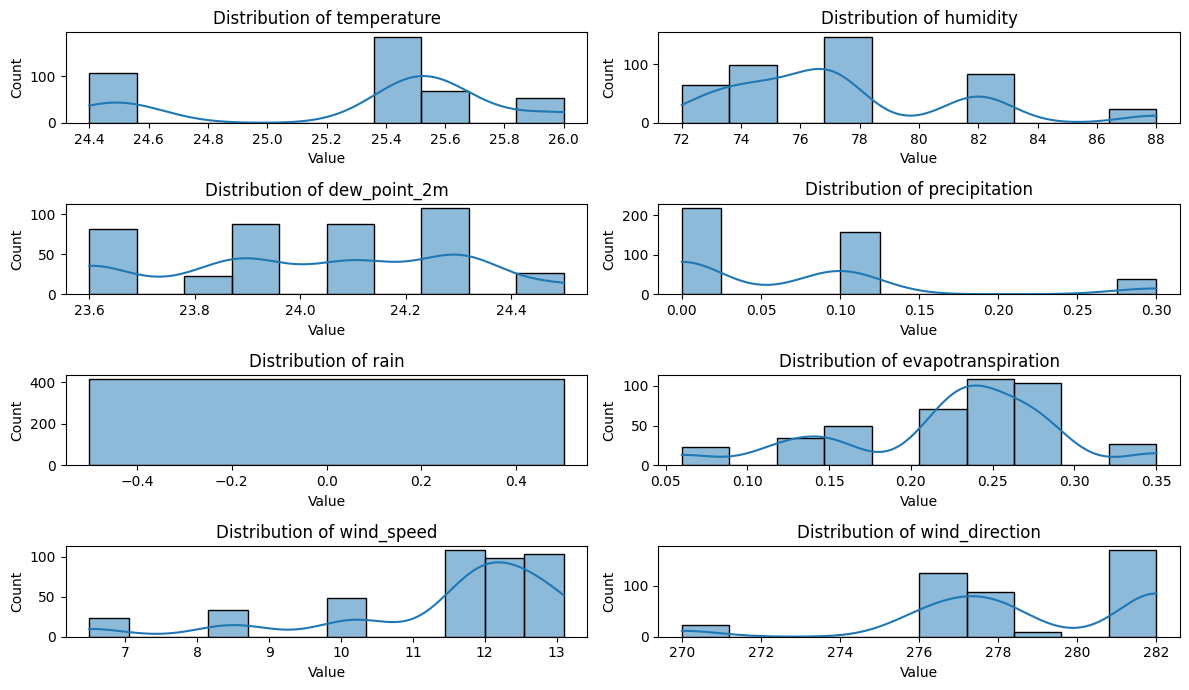

In [24]:
# Create a 4x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over columns and plot on each subplot
for i, col in enumerate(cols_to_check_suction):
    sns.histplot(df_suction[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

# Hide the empty subplots
for j in range(len(cols_to_check_suction), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [25]:
cols_to_check_moisture = ['temperature', 'humidity', 'dew_point_2m', 'precipitation', 'rain', 'evapotranspiration', 'wind_speed', 'wind_direction']
outliers_by_col = check_outliers_by_column(df_moisture.copy(), cols_to_check_moisture)

# Print outliers for each column
for col, outliers in outliers_by_col.items():
  if not outliers.empty:
    print(f"There are outliers for column {col}:", len(outliers))
  else:
    print(f"No outliers detected for column {col}.")

No outliers detected for column temperature.
There are outliers for column humidity: 113
There are outliers for column dew_point_2m: 90
There are outliers for column precipitation: 153
No outliers detected for column rain.
No outliers detected for column evapotranspiration.
No outliers detected for column wind_speed.
There are outliers for column wind_direction: 90


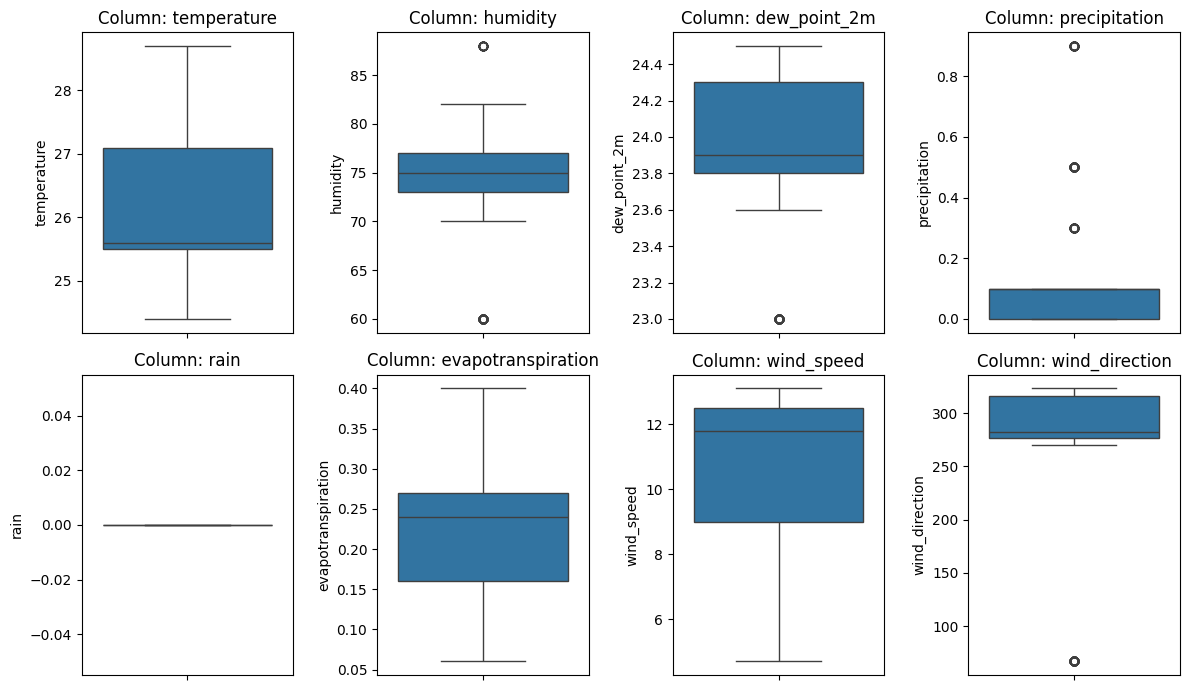

In [26]:
# Create a 4x2 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over columns and plot on each subplot
for i, col in enumerate(cols_to_check_moisture):
    sns.boxplot(data=df_moisture[col], ax=axes[i])
    axes[i].set_title(f'Column: {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide the empty subplots
for j in range(len(cols_to_check_moisture), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

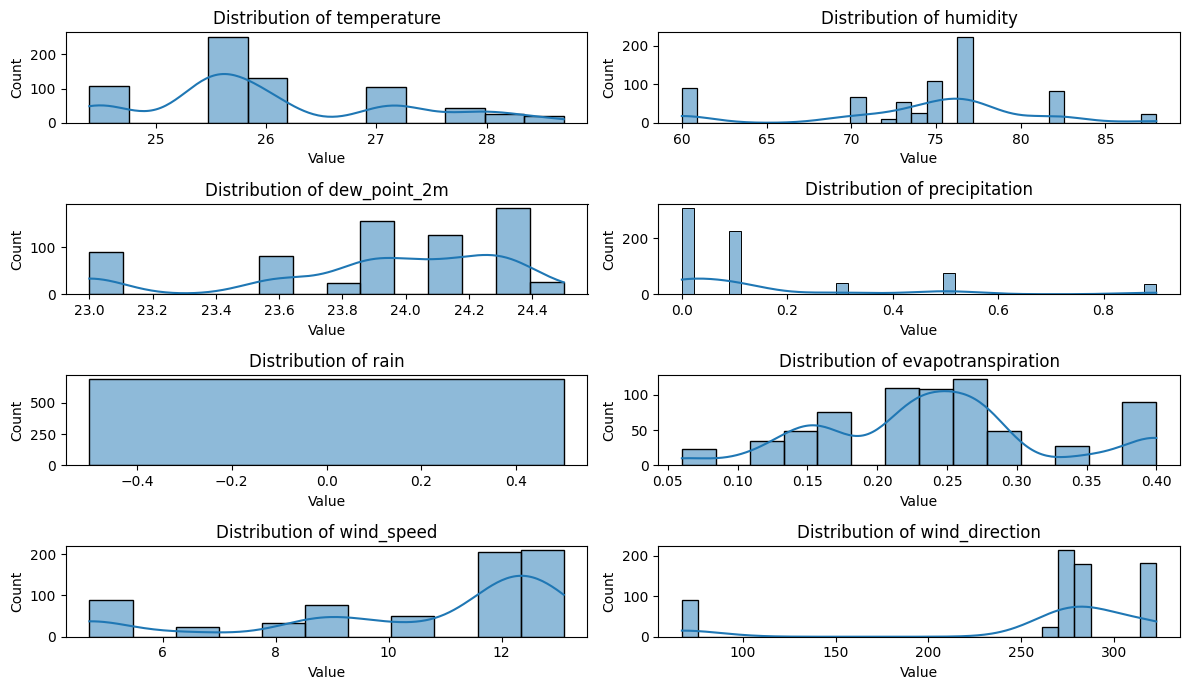

In [27]:
# Create a 4x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over columns and plot on each subplot
for i, col in enumerate(cols_to_check_moisture):
    sns.histplot(df_moisture[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

# Hide the empty subplots
for j in range(len(cols_to_check_moisture), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### **Comparation in General**

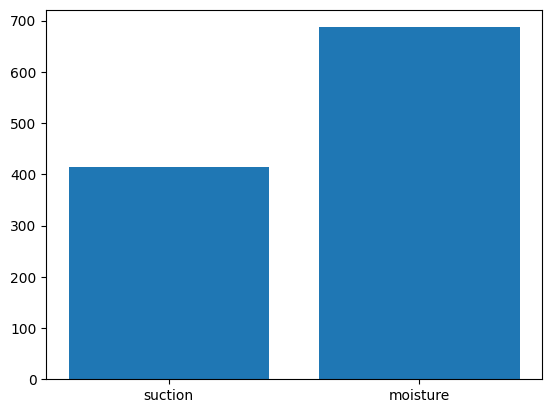

In [28]:
length_of_valid_data = {
    "suction": len(df_suction),
    "moisture": len(df_moisture)
}

plt.bar(length_of_valid_data.keys(), length_of_valid_data.values())
plt.show()

Note: There is a possibility where the model can easily capture the pattern insight the moisture but not suction.

###**Cross Validation Technique**

In [29]:
df_suction.columns == df_moisture.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [30]:
df.columns == df_moisture.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [31]:
df.columns == df_suction.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [32]:
df.columns

Index(['longitude', 'latitude', 'temperature', 'moisture', 'suction_pressure',
       'humidity', 'dew_point_2m', 'precipitation', 'rain', 'weather_code',
       'evapotranspiration', 'wind_speed', 'wind_direction', 'combine_loc'],
      dtype='object')

In [33]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF  # Radial Basis Function kernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

target_label  = ['moisture', 'suction_pressure']
misc_feature  = ['combine_loc', 'weather']

features_suction  = [col for col in df.columns if col not in target_label and col not in misc_feature]
features_moisture = [col for col in df.columns if col not in target_label and col not in misc_feature]

X_suction, X_moisture = df_suction[features_suction], df_moisture[features_moisture]
y_suction, y_moisture = df_suction['suction_pressure'], df_moisture['moisture']

cv = KFold(n_splits=7, shuffle=True, random_state=1024)

for model in [RandomForestRegressor()]:
  mse_suction  = []
  mae_suction  = []
  r2_suction   = []
  mse_moisture = []
  mae_moisture = []
  r2_moisture  = []

  model_suction = model
  model_moisture = model

  for train_index, test_index in cv.split(X_suction):
    X_train_suction, X_test_suction = X_suction.iloc[train_index], X_suction.iloc[test_index]
    y_train_suction, y_test_suction = y_suction.iloc[train_index], y_suction.iloc[test_index]

    model_suction.fit(X_train_suction, y_train_suction)

    suction_pred = model_suction.predict(X_test_suction)
    mae_suction.append(mean_absolute_error(y_test_suction, suction_pred))
    mse_suction.append(mean_squared_error(y_test_suction, suction_pred))
    r2_suction.append(r2_score(y_test_suction, suction_pred))

  for train_index, test_index in cv.split(X_moisture):
    X_train_moisture, X_test_moisture = X_moisture.iloc[train_index], X_moisture.iloc[test_index]
    y_train_moisture, y_test_moisture = y_moisture.iloc[train_index], y_moisture.iloc[test_index]

    model_moisture.fit(X_train_moisture, y_train_moisture)

    moisture_pred = model_moisture.predict(X_test_moisture)
    mae_moisture.append(mean_absolute_error(y_test_moisture, moisture_pred))
    mse_moisture.append(np.sqrt(mean_squared_error(y_test_moisture, moisture_pred)))
    r2_moisture.append(r2_score(y_test_moisture, moisture_pred))

  # Print average metrics for each model
  print(type(model).__name__)
  print('Average MAE of suction:', np.mean(mae_suction))
  print('Average MSE of suction:', np.mean(mse_suction))
  print('Average R-squared of suction:', np.mean(r2_suction))
  print('='*50)
  print('Average MAE of moisture:', np.mean(mae_moisture))
  print('Average MSE of moisture:', np.mean(mse_moisture))
  print('Average R-squared of moisture:', np.mean(r2_moisture))
  print("\n")

RandomForestRegressor
Average MAE of suction: 0.2106026287804705
Average MSE of suction: 0.11508303365666814
Average R-squared of suction: 0.9777377596671525
Average MAE of moisture: 0.09041756781022134
Average MSE of moisture: 0.16707719501245877
Average R-squared of moisture: 0.9997666194548306




In [34]:
target_label  = ['moisture', 'suction_pressure']
misc_feature  = ['combine_loc', 'weather']

features_suction  = [col for col in df.columns if col not in target_label and col not in misc_feature]
features_moisture = [col for col in df.columns if col not in target_label and col not in misc_feature]

X_suction, X_moisture = df_suction[features_suction], df_moisture[features_moisture]
y_suction, y_moisture = df_suction['suction_pressure'], df_moisture['moisture']

cv = KFold(n_splits=7)

for model in [RandomForestRegressor()]:
  mse_suction  = []
  mae_suction  = []
  r2_suction   = []
  mse_moisture = []
  mae_moisture = []
  r2_moisture  = []

  model_suction = model
  model_moisture = model

  for train_index, test_index in cv.split(X_suction):
    X_train_suction, X_test_suction = X_suction.iloc[train_index], X_suction.iloc[test_index]
    y_train_suction, y_test_suction = y_suction.iloc[train_index], y_suction.iloc[test_index]

    model_suction.fit(X_train_suction, y_train_suction)

    suction_pred = model_suction.predict(X_test_suction)
    mae_suction.append(mean_absolute_error(y_test_suction, suction_pred))
    mse_suction.append(mean_squared_error(y_test_suction, suction_pred))
    r2_suction.append(r2_score(y_test_suction, suction_pred))

  for train_index, test_index in cv.split(X_moisture):
    X_train_moisture, X_test_moisture = X_moisture.iloc[train_index], X_moisture.iloc[test_index]
    y_train_moisture, y_test_moisture = y_moisture.iloc[train_index], y_moisture.iloc[test_index]

    model_moisture.fit(X_train_moisture, y_train_moisture)

    moisture_pred = model_moisture.predict(X_test_moisture)
    mae_moisture.append(mean_absolute_error(y_test_moisture, moisture_pred))
    mse_moisture.append(np.sqrt(mean_squared_error(y_test_moisture, moisture_pred)))
    r2_moisture.append(r2_score(y_test_moisture, moisture_pred))

  # Print average metrics for each model
  print(type(model).__name__)
  print('Average MAE of suction:', np.mean(mae_suction))
  print('Average MSE of suction:', np.mean(mse_suction))
  print('Average R-squared of suction:', np.mean(r2_suction))
  print('='*50)
  print('Average MAE of moisture:', np.mean(mae_moisture))
  print('Average MSE of moisture:', np.mean(mse_moisture))
  print('Average R-squared of moisture:', np.mean(r2_moisture))
  print("\n")

RandomForestRegressor
Average MAE of suction: 1.2462547331202136
Average MSE of suction: 3.4908692139670783
Average R-squared of suction: -22.6555316859752
Average MAE of moisture: 5.592792609314587
Average MSE of moisture: 7.325431317334735
Average R-squared of moisture: 0.15204729899112496




In [35]:
cv_suction  = GroupKFold(n_splits=len(df_suction['combine_loc'].unique()))
cv_moisture = GroupKFold(n_splits=len(df_moisture['combine_loc'].unique()))

groups_suction  = df_suction['combine_loc']
groups_moisture = df_moisture['combine_loc']

for model in [RandomForestRegressor()]:
    mse_suction  = []
    mae_suction  = []
    r2_suction   = []
    mse_moisture = []
    mae_moisture = []
    r2_moisture  = []

    model_suction  = model
    model_moisture = model

    for train_index, test_index in cv_suction.split(X_suction, y_suction, groups=groups_suction):
        X_train_suction, X_test_suction = X_suction.iloc[train_index], X_suction.iloc[test_index]
        y_train_suction, y_test_suction = y_suction.iloc[train_index], y_suction.iloc[test_index]

        model_suction.fit(X_train_suction, y_train_suction)

        suction_pred = model_suction.predict(X_test_suction)
        mae_suction.append(mean_absolute_error(y_test_suction, suction_pred))
        mse_suction.append(mean_squared_error(y_test_suction, suction_pred))
        r2_suction.append(r2_score(y_test_suction, suction_pred))

    for train_index, test_index in cv_moisture.split(X_moisture, y_moisture, groups=groups_moisture):
        X_train_moisture, X_test_moisture = X_moisture.iloc[train_index], X_moisture.iloc[test_index]
        y_train_moisture, y_test_moisture = y_moisture.iloc[train_index], y_moisture.iloc[test_index]

        model_moisture.fit(X_train_moisture, y_train_moisture)

        moisture_pred = model_moisture.predict(X_test_moisture)
        mae_moisture.append(mean_absolute_error(y_test_moisture, moisture_pred))
        mse_moisture.append(np.sqrt(mean_squared_error(y_test_moisture, moisture_pred)))
        r2_moisture.append(r2_score(y_test_moisture, moisture_pred))

    # Print average metrics for each model
    print(type(model).__name__)
    print('Average MAE of suction:', np.mean(mae_suction))
    print('Average MSE of suction:', np.mean(mse_suction))
    print('Average R-squared of suction:', np.mean(r2_suction))
    print('='*50)
    print('Average MAE of moisture:', np.mean(mae_moisture))
    print('Average MSE of moisture:', np.mean(mse_moisture))
    print('Average R-squared of moisture:', np.mean(r2_moisture))
    print("\n")

RandomForestRegressor
Average MAE of suction: 2.453914716953817
Average MSE of suction: 7.417176665377377
Average R-squared of suction: -1413.2784087624113
Average MAE of moisture: 18.850605469830967
Average MSE of moisture: 19.17681815487762
Average R-squared of moisture: -23515.941414882753




In [37]:
df_moisture.to_csv('complete_moisture_data.csv', index=False)
df_suction.to_csv('complete_suction_data.csv', index=False)

In [36]:
# Previous implementation by manually select the best model from cross validation

import pickle

with open('moisture_model.pkl', 'wb') as f:
    pickle.dump(model_moisture, f)

with open('suction_model.pkl', 'wb') as f:
    pickle.dump(model_suction, f)

##For Interpolation (Further Development)
note: if number of sensor is already possible to send many data at the same time

*   Imanian, H., Shirkhani, H., Mohammadian, A., Cobo, J. H., & Payeur, P. (2023). Spatial interpolation of soil temperature and water content in the land-water interface using artificial intelligence.  Water, 15(3), 473. https://doi.org/10.3390/w15030473



In [ ]:
df_interpolation = df.copy()
df_interpolation['combine_loc'] = '(' + df_interpolation['latitude'].astype(str) + ', ' + df_interpolation['longitude'].astype(str) + ')'
df_interpolation

In [ ]:
df_interpolation.info()

In [ ]:
df_interpolation['combine_loc'].value_counts()

In [ ]:
df_interpolation.loc[df_interpolation['suction_pressure'] != 0].combine_loc.value_counts()

In [ ]:
def data_preprocessor_interpolation_pipeline(df, metric):
  df_new = df.copy()
  df_new['combine_loc'] = '(' + df_new['latitude'].astype(str) + ', ' + df_new['longitude'].astype(str) + ')'
  suction_test = df_new.loc[df_new['suction_pressure'] == 0, 'combine_loc'].value_counts().keys()

  mean_metric_raw_dict = dict(df_new.loc[~df_new['combine_loc'].isin(suction_test)].groupby('combine_loc')[metric].mean())
  mean_metric_df = pd.DataFrame({
      'combine_loc': mean_metric_raw_dict.keys(),
      f'{metric}': mean_metric_raw_dict.values()
  })

  mean_metric_df[['latitude', 'longitude']] = mean_metric_df['combine_loc'].str.extract(r'\((.*),(.*)\)').astype(float)
  mean_metric_df.drop(columns=['combine_loc'], inplace=True)

  return mean_metric_df

In [ ]:
mean_moisture_df = data_preprocessor_interpolation_pipeline(df_interpolation, 'moisture')
mean_moisture_df

In [ ]:
mean_suction_df = data_preprocessor_interpolation_pipeline(df_interpolation.loc[df_interpolation['suction_pressure'] != 0], 'suction_pressure')
mean_suction_df

In [ ]:
mean_suction_df.info()

In [ ]:
# Specify the coordinates for the new location
new_latitude = -6.369937
new_longitude = 106.829574

# Create Ordinary Kriging models for each parameter
OK_moisture = OrdinaryKriging(mean_moisture_df['longitude'], mean_moisture_df['latitude'], mean_moisture_df['moisture'])
OK_suction = OrdinaryKriging(mean_suction_df['longitude'], mean_suction_df['latitude'], mean_suction_df['suction_pressure'])

# Interpolate values for the new location
moisture_interp, _ = OK_moisture.execute('points', [new_longitude], [new_latitude])
suction_interp, _ = OK_suction.execute('points', [new_longitude], [new_latitude])

print(f"Interpolated values for coordinate ({new_latitude}, {new_longitude}):")
print(f"Estimated Soil Suction Pressure: {suction_interp[0]:.2f}")
print(f"Estimated Soil Moisture: {moisture_interp[0]:.2f}")